# Generate MBDyn motion path input from CSim data
Fabian Wendt, NREL, 2018

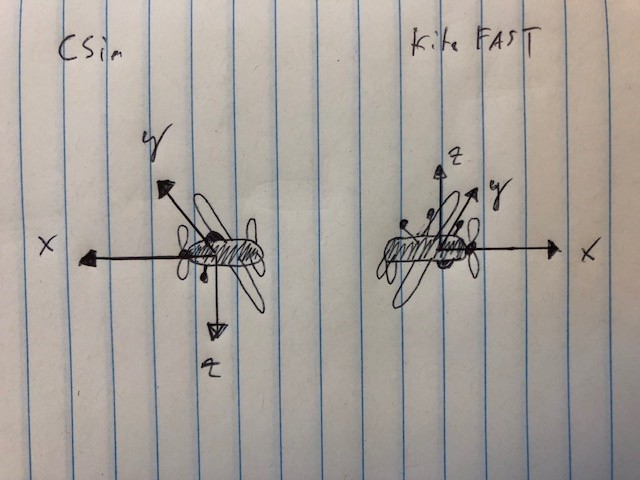

In [3]:
#run this to activate the debugger
#import pixiedust

In [4]:
#uncomment the next line to use the debugger
#%%pixie_debugger

import pandas as pd

import sys
#!!!!!REQUIRES scipy>1.3.0.dev0+47976a8
#Also, comment out the following code in scipy/spatial/transform/rotation.py:
#In the as_rotvec function comment out:
#>>>  quat[quat[:, 3] < 0.0] *= -1  <<<
#This avoids flips in the orientation of the rotation vectors (MBdyn does not like this).
import scipy
from scipy.spatial.transform import Rotation as R
#print your scipy version
print(scipy.__version__)
import os

#Read the CSim data
xls = pd.ExcelFile("CSim_ORIGINALFW.xlsx")
sheetX = xls.parse(0) #2 is the sheet number
time = sheetX['time']
xposCSim = sheetX['wing_x']
yposCSim = sheetX['wing_y']
zposCSim = sheetX['wing_z']
rollCSim = sheetX['wing_roll']
pitchCSim = sheetX['wing_pitch']
yawCSim = sheetX['wing_yaw']


#Initialize a few variables
global_pos=np.zeros([len(time),3])
csimangles=np.zeros([len(time),3])
angles_for_plt=np.zeros([len(time),4])
eulerCangles=np.zeros([len(time),3])
vec_r_old=np.zeros([3])
i = 0
new_flip=False
old_flip=False

#convert the CSim data into MBdyn format
while i < len(time):
    #Changing the CSim coordinates to align with the KiteFAST Coordinate System
    #CSim and KiteFAST Coordinate Systems are rotated -180deg around the Y-axis relative to each other
    #CSim: Z down, Y as in KiteFAST, X follows right hand rule
    CSimpos=np.array([xposCSim[i],yposCSim[i],zposCSim[i]])
    global_pos[i,0]=-CSimpos[0]
    global_pos[i,1]=CSimpos[1]
    global_pos[i,2]=-CSimpos[2]
    #CSim rotations are specified as Euler angles (3,2,1 sequence), transforming them to a rotation vector.
    #The KiteFAST model initializes upside down.
    #The first rotation is about yaw, since at this point KiteFAST and CSim yaw axis are opposite, we add a minus.
    #The second roation is about pitch. The Pitch axis in KF and CSim are alignes. We substract Pi to flip the model.
    #The thrid rotation is about roll. At this point the KF and CSim roll axis align. No minus needed here.    
    
    r=R.from_euler('ZYX',np.array([-yawCSim[i], pitchCSim[i]-np.pi, rollCSim[i]]), degrees=False)
    vec_r=r.as_rotvec()
    #dcm_r=r.as_dcm()
   
    # now we are checking for vector flips, which cause issues with MBdyn
    if i==0:
        vec_r_old=np.copy(vec_r)
        
    if (np.linalg.norm(vec_r_old)>0.0):
        #this is not the first step, so we check if vector flips
        if ( np.sign(vec_r[0])!=np.sign(vec_r_old[0]) \
            and np.sign(vec_r[1])!=np.sign(vec_r_old[1]) \
            and np.sign(vec_r[2])!=np.sign(vec_r_old[2]) ):
            #a flip has happend!
            if (new_flip==False and old_flip==False):
                #this is a new flip, there is no previous flip
                new_flip=True
            elif (old_flip==True and new_flip==True):
                #we already had two previous flips, this is a third one, we treat this as a new flip without previous ones
                new_flip=True
                old_flip=False
            else:
                #we already had one flip and now we have another one
                new_flip=True
                old_flip=True
        
        vec_r_old=np.copy(vec_r)
    
        if (new_flip==True and old_flip==False):
            #flipping the vector (only if we have an odd number of flips)
            vec_r[0]=-vec_r[0]
            vec_r[1]=-vec_r[1]
            vec_r[2]=-vec_r[2]
            scale_fact=np.absolute(np.linalg.norm(vec_r)-np.pi*2)/np.linalg.norm(vec_r)
            vec_r[0]=vec_r[0]*scale_fact
            vec_r[1]=vec_r[1]*scale_fact
            vec_r[2]=vec_r[2]*scale_fact 
    
    euler_check=r.as_euler('ZYX', degrees=False)
    csimangles[i,0:3]=vec_r
    eulerCangles[i,0:3]=euler_check

    if i==0:
        #computing the DCMs used to initialize the MBDyn model
        r1=R.from_rotvec(vec_r)
        dcm_mat=r1.as_dcm()
        #The columns shown here are the body CS system unity vectors in the global CS
        print(dcm_mat)
        #The angles used for initialization in the preprocessor
        print('yaw pitch roll initial angle [deg]:')
        print(np.array([np.degrees(-yawCSim[i]), np.degrees(pitchCSim[i]-np.pi), np.degrees(rollCSim[i])]))
        print('yaw pitch roll initial angle [rad]:')
        print(np.array([-yawCSim[i], pitchCSim[i]-np.pi, rollCSim[i]]))
    
    i += 1

    
#ramp for ICS
t_ramp=0.0 #This is the time for the ramp used to move the model from its inital position to the start point of the
t_ramp_circle=2.0
#prescribed flight path.
init_vec=np.array([124.972, -379.855, 173.733, -2.353150597, 0.0834282778, 0.6816017752]) #This is the inital position of the model.

#some initialization
t_step=time[1]
t_cur=0
linc=0
ramp_sec=np.zeros([int(t_ramp/t_step),7])


while t_cur<(t_ramp-t_step):
    ramp_sec[linc,0]=t_cur
    ramp_sec[linc,1]=np.interp(t_cur,np.array([0, t_ramp]),np.array([init_vec[0],global_pos[0,0]])) #x
    ramp_sec[linc,2]=np.interp(t_cur,np.array([0, t_ramp]),np.array([init_vec[1],global_pos[0,1]])) #y
    ramp_sec[linc,3]=np.interp(t_cur,np.array([0, t_ramp]),np.array([init_vec[2],global_pos[0,2]])) #z
    ramp_sec[linc,4]=np.interp(t_cur,np.array([0, t_ramp]),np.array([init_vec[3],csimangles[0,0]])) #roll
    ramp_sec[linc,5]=np.interp(t_cur,np.array([0, t_ramp]),np.array([init_vec[4],csimangles[0,1]])) #pitch
    ramp_sec[linc,6]=np.interp(t_cur,np.array([0, t_ramp]),np.array([init_vec[5],csimangles[0,2]])) #yaw
    t_cur=t_cur+t_step
    linc=linc+1
    
time_np=time.as_matrix()

input_data=np.column_stack((time_np,global_pos,csimangles))
final_ar=np.row_stack((ramp_sec,input_data))
final_ar[:,0]=np.linspace(0,t_ramp+final_ar[-1,0],final_ar.shape[0])   


#Everything in the block below is added to ramp up the velocity 

#initializing a few things here
final_ar_temp=np.zeros(([1,7]))
t_cur_in=t_ramp
t_cur_out=0.0
linc=int(t_cur_in/t_step)
t_cur_out=t_cur_in
first_run=1

#creating the ramped flight patch here
while t_cur_in<t_ramp_circle:
    if t_cur_in==t_ramp:
        fact=int(round(t_ramp_circle/t_step))
    else:
        fact=int(round(t_ramp_circle/(t_cur_in-t_ramp)))
    
    t_cur_out_start=t_cur_out
    for rep in range(fact):
        if first_run==1:
            final_ar_temp[0,:]=final_ar[linc,:]
            first_run=0
            final_ar_temp[0,0]=t_cur_out
        else:
            input_ar_x=np.interp(t_cur_out,np.array([t_cur_out_start, t_cur_out_start+fact*t_step]),np.array([final_ar[linc,1], final_ar[linc+1,1]]))
            input_ar_y=np.interp(t_cur_out,np.array([t_cur_out_start, t_cur_out_start+fact*t_step]),np.array([final_ar[linc,2], final_ar[linc+1,2]]))
            input_ar_z=np.interp(t_cur_out,np.array([t_cur_out_start, t_cur_out_start+fact*t_step]),np.array([final_ar[linc,3], final_ar[linc+1,3]]))
            input_ar_rot1=np.interp(t_cur_out,np.array([t_cur_out_start, t_cur_out_start+fact*t_step]),np.array([final_ar[linc,4], final_ar[linc+1,4]]))
            input_ar_rot2=np.interp(t_cur_out,np.array([t_cur_out_start, t_cur_out_start+fact*t_step]),np.array([final_ar[linc,5], final_ar[linc+1,5]]))
            input_ar_rot3=np.interp(t_cur_out,np.array([t_cur_out_start, t_cur_out_start+fact*t_step]),np.array([final_ar[linc,6], final_ar[linc+1,6]]))
            input_ar=np.array([t_cur_out, input_ar_x, input_ar_y, input_ar_z, input_ar_rot1, input_ar_rot2, input_ar_rot3])
            #print(input_ar)
            final_ar_temp=np.vstack((final_ar_temp,input_ar))
            #final_ar_temp[-1,0]=t_cur_out
        t_cur_out=t_cur_out+t_step
    t_cur_in=t_cur_in+t_step
    linc=linc+1

#patching together the final array for the flight path
if t_ramp>0.0:
    final_ar_scratch=final_ar[0:int(t_ramp/t_step)] 
if t_ramp_circle>0.0:
    final_ar_scratch=np.vstack((final_ar_scratch,final_ar_temp))
    final_ar_scratch=np.vstack((final_ar_scratch,final_ar[linc:,:]))
else:
    #we do not have any ramps here
    final_ar_scratch=final_ar

#making sure the time index makes sense
lc=0
tc=0
length_fa=final_ar_scratch.shape
while lc<length_fa[0]:
    final_ar_scratch[lc,0]=tc
    tc=tc+t_step
    lc=lc+1
       
#print(final_ar_temp)
#final_ar_scratch[:,1]=final_ar_scratch[:,1]-6.917
#final_ar_scratch[:,2]=final_ar_scratch[:,2]-0.0
#final_ar_scratch[:,3]=final_ar_scratch[:,3]+0.039
    
#create final CSV file
#np.savetxt("position.csv", final_ar, delimiter="\t")
#np.savetxt("position_TEST.csv", final_ar_temp, delimiter="\t")
np.savetxt("position.csv", final_ar_scratch, delimiter="\t")

#compute and print initial velocity
vx=(final_ar_scratch[1,1]-final_ar_scratch[0,1])/t_step;
vy=(final_ar_scratch[1,2]-final_ar_scratch[0,2])/t_step;
vz=(final_ar_scratch[1,3]-final_ar_scratch[0,3])/t_step;

#print(final_ar_scratch[0,:])
print("initial tanslational velocity")
print(np.array([vx,vy,vz]))

1.3.0.dev0+6229c57


FileNotFoundError: [Errno 2] No such file or directory: 'CSim_ORIGINALFW.xlsx'

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline


#printing the components of the rotation vector, there should be no discontinuities here
plt.plot(final_ar[:,0],final_ar[:,4],label='rot1')
plt.plot(final_ar[:,0],final_ar[:,5],label='rot2')
plt.plot(final_ar[:,0],final_ar[:,6],label='rot3')
plt.xlim((0, 60))
plt.grid()
plt.legend()
plt.show()

In [ ]:
print(final_ar_temp)